<a href="https://colab.research.google.com/github/aryashivakumar/dataScience/blob/main/Unit4/Arya_Kumar_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
# Load dataset
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

# Compute theoretical - experimental difference
cs_data["diff_TminusE"] = cs_data.theo - cs_data.exp

# Encode amino acids
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

# Student T model
with pm.Model(coords=aa_coords) as cs_h_model_T:
    μ_mu = pm.StudentT('μ_mu', mu=0, sigma=10, nu=30)
    μ_sd = pm.HalfStudentT('μ_sd', sigma=10, nu=30)
    μ_nm = pm.HalfStudentT('μ_nm', sigma=10, nu=30)
    μ = pm.StudentT('μ', mu=μ_mu, sigma=μ_sd, nu=μ_nm, dims="aa")
    σ = pm.HalfStudentT('σ', sigma=10, nu=30, dims="aa")
    ν = pm.HalfStudentT('ν', sigma=10, nu=30, dims="aa")
    y = pm.StudentT('y', mu=μ[aa_idx], sigma=σ[aa_idx], nu=ν[aa_idx],
                    observed=cs_data.diff_TminusE)
    idata_T = pm.sample()

# Normal model
with pm.Model(coords=aa_coords) as cs_h_model_N:
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', sigma=10)
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa")
    σ = pm.HalfNormal('σ', sigma=10, dims="aa")
    y = pm.Normal('y', mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data.diff_TminusE)
    idata_N = pm.sample()

# Compare posteriors
axes = az.plot_forest([idata_T, idata_N], kind="ridgeplot",
                      model_names=['StudentT', 'Normal'],
                      var_names='μ', combined=True, figsize=(12,10), hdi_prob=0.997)
axes[0].vlines(idata_T.posterior['μ_mu'].mean(), *axes[0].get_ylim(), color="k", ls=":")

The Student-T model pulls the posteriors closer to every amino acids's mean and better handles the outliers. The normal model however, distributed too evenly making the tails lighter and less strong to more heavy tailed chemical shift differences

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

Output()

(-15.0, 15.0)

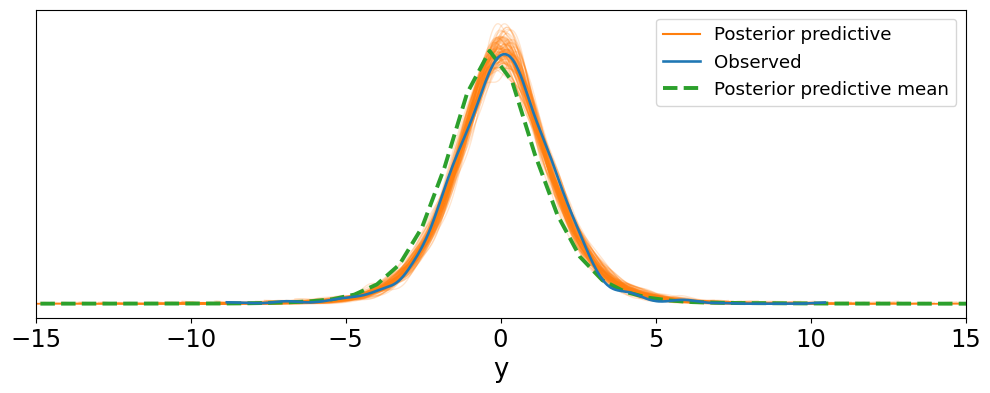

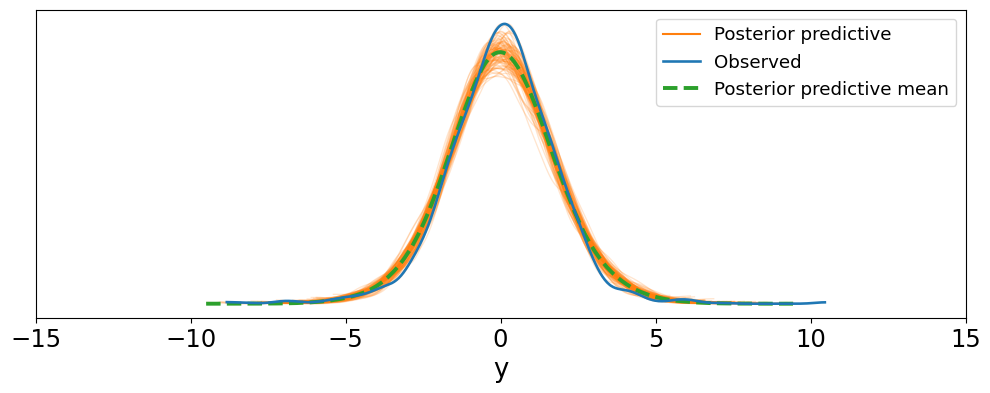

In [4]:
pm.sample_posterior_predictive(idata_T, model=cs_h_model_T, extend_inferencedata=True)
az.plot_ppc(idata_T, num_pp_samples=100, figsize=(12,4), colors=["C1","C0","C2"]).set_xlim(-15,15)

pm.sample_posterior_predictive(idata_N, model=cs_h_model_N, extend_inferencedata=True)
az.plot_ppc(idata_N, num_pp_samples=100, figsize=(12,4), colors=["C1","C0","C2"]).set_xlim(-15,15)


The Student-T model replicates the distribution much better, as it captures the tails and peak region that the normal model underestimates.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr, dtype={'position': 'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
coords = {"pos": pos_codes}

with pm.Model(coords=coords) as sccr_nh:
    μ_p = pm.Beta("μ_p", mu=1/11, nu=55, dims="pos")
    ν_p = pm.Gamma("ν_p", mu=55, sigma=45, dims="pos")
    θ = pm.Beta("θ", mu=μ_p[pos_idx], nu=ν_p[pos_idx])
    _ = pm.Binomial("gs", n=sccr_data.shots.values, p=θ, observed=sccr_data.goals.values)
    idata_nh = pm.sample(target_accept=0.99)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.001 0.9994 1.001 ... 1.0 1.0 0.9999
    μ_p      (pos) float64 32B 1.002 0.9992 1.038 0.9998
    ν_p      (pos) float64 32B 1.011 1.003 1.126 1.015

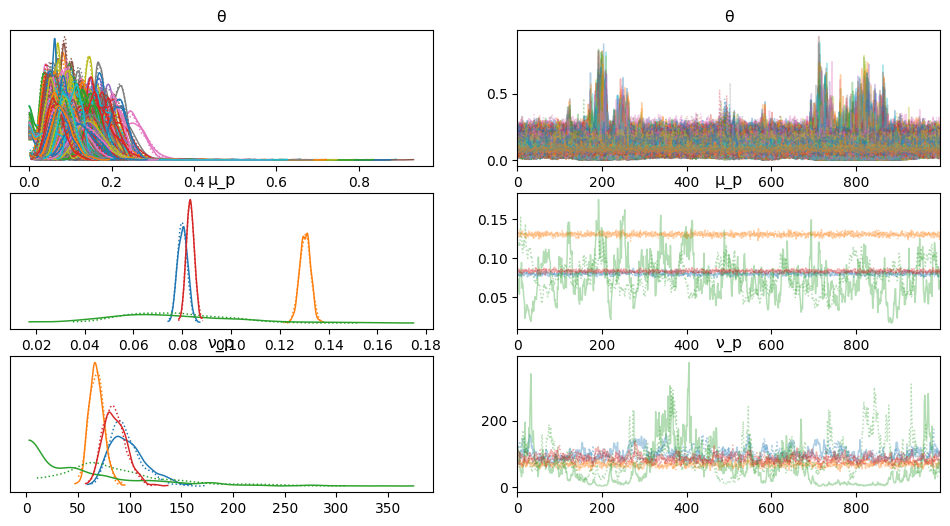

In [10]:
az.plot_trace(idata_nh)
az.rhat(idata_nh)

The non hiercahcial models R values ar slightly worse than the hierchical version, espcially for Vp. However, the theta and Mu P parameters stay very close to 1.0, which means that the convergence was still acceptable though noisier without the shared information

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

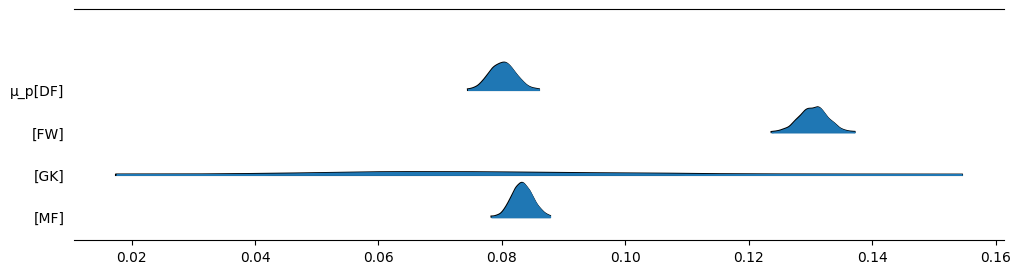

In [11]:
az.plot_forest(idata_nh, var_names=['μ_p'], combined=True,
               kind='ridgeplot', figsize=(12,3), hdi_prob=0.998)

The non-hierchial model produces similar posterior meansas before, but has larger varience. There is reduced variance, tightening the intervals around the mean

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
sccr_data_new = pd.read_csv(url_sccr)
sccr_data_new = sccr_data_new.query('position != "GK"')
sccr_data_new['position'] = sccr_data_new['position'].astype('category')

pos_idx_new = sccr_data_new.position.cat.codes.values
pos_codes_new = sccr_data_new.position.cat.categories
coords_new = {"pos": pos_codes_new}

with pm.Model(coords=coords_new) as sccr_h:
    μ = pm.Beta('μ', alpha=2, beta=20)
    ν = pm.Gamma('ν', mu=55, sigma=45)
    μ_p = pm.Beta('μ_p', mu=μ, nu=ν, dims="pos")
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")
    θ = pm.Beta('θ', mu=μ_p[pos_idx_new], nu=ν_p[pos_idx_new])
    _ = pm.Binomial('gs', n=sccr_data_new.shots, p=θ, observed=sccr_data_new.goals)
    idata_h = pm.sample(target_accept=0.95)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 1.001 1.001 ... 0.9994 0.9993 1.001
    μ        float64 8B 1.005
    μ_p      (pos) float64 24B 1.006 1.002 1.0
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.004 0.9998 1.013

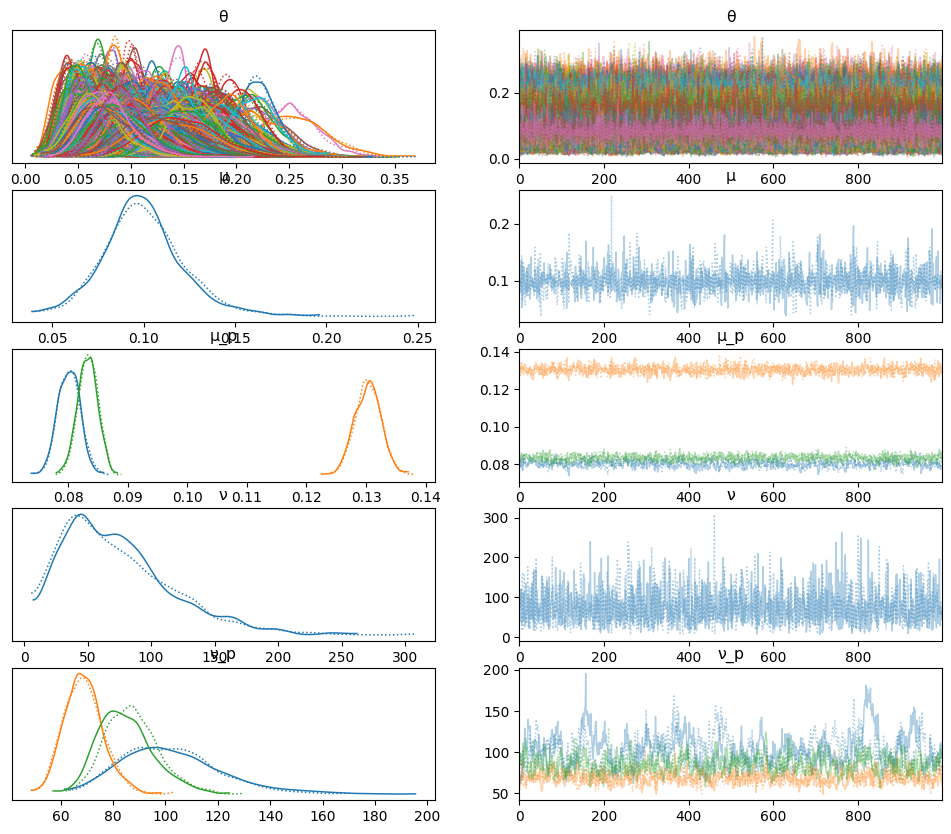

In [13]:
az.plot_trace(idata_h)
az.rhat(idata_h)

Removing the Goal Keeper data changed the runtime and gave a R of 1.00 across all the parameters which showcases stronger convergence. Dropping the GK reduces the diversity of sampling slightly but improves the conssitentcy and reliability, the model dosen't struggle w groups whose shot goal data are irregular.